# Downtown Brooklyn Collisions Study - Step-by-Step
This notebook walks through analyzing motor vehicle collisions in Downtown Brooklyn using UrbanMapper.
We’ll load collision data, map it to intersections, count collisions per node, and visualise the results.

In [1]:
import urban_mapper as um

# Initialise UrbanMapper
mapper = um.UrbanMapper()

# Step 1: Create urban layer for intersections
layer = (
    mapper.urban_layer
    .with_type("streets_intersections")
    .from_place("Downtown Brooklyn, New York City, USA", network_type="drive")
    .build()
)

In [ ]:
# Step 2: Load collision data
data = (
    mapper.loader
    .from_file("./NYC_Motor_Vehicle_Collisions_Mar_12_2025.csv")
    .with_columns(longitude_column="LONGITUDE", latitude_column="LATITUDE")
    .load()
)

In [ ]:

# Step 3: Impute missing coordinates
imputer = (
    mapper.imputer
    .with_type("SimpleGeoImputer")
    .on_columns("LONGITUDE", "LATITUDE")
    .build()
)
data = imputer.transform(data, layer)

In [4]:
# Step 4: Filter to bounding box
filter_step = mapper.filter.with_type("BoundingBoxFilter").build()
data = filter_step.transform(data, layer)

In [5]:
# Step 5: Map to nearest intersections
_, mapped_data = layer.map_nearest_layer(
    data,
    longitude_column="LONGITUDE",
    latitude_column="LATITUDE",
    output_column="nearest_intersection"
)

In [6]:

# Step 6: Enrich with collision counts
enricher = (
    mapper.enricher
    .with_data(group_by="nearest_intersection")
    .count_by(output_column="collision_count")
    .build()
)
enriched_layer = enricher.enrich(mapped_data, layer)

In [7]:
# Step 7: Visualize interactively
visualiser = (
    mapper.visual
    .with_type("Interactive")
    .with_style({"tiles": "CartoDB dark_matter"})
    .build()
)
fig_interactive = visualiser.render(enriched_layer.get_layer(), columns=["collision_count"])
fig_interactive

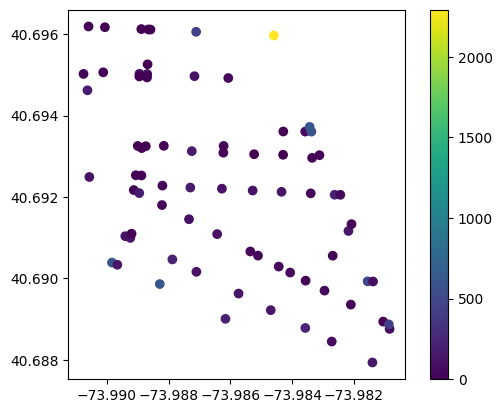

In [9]:
# Step 8: Visualize statically
visualiser = mapper.visual.with_type("Static").build()
fig_static = visualiser.render(enriched_layer.get_layer(), columns=["collision_count"])